<a href="https://colab.research.google.com/github/itsMeJunaid/Health-Risk-Predictor-Full-Stack-ML-Application/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Brain Tumor Detection from MRI Scans

---

##  1. Problem Definition

### Objective:  
Develop a deep learning model to **classify MRI brain scans** into two categories:  
- `Tumor`  
- `No Tumor`

---

 **Problem Type:**
This is a **binary image classification** task using supervised learning.

---

**Goal:**  
- Achieve **>95% test accuracy**
- Maintain **high recall**, especially for detecting the **Tumor** class (false negatives must be minimized).

---

**Why It Matters:**  
Timely and accurate detection of brain tumors can help with:
- Early intervention
- Reduced diagnosis delay
- Improved patient survival rate

This model aims to **assist radiologists** by highlighting risky cases quickly and reliably using MRI scan analysis.


### What is Brain Tumor?¶
A brain tumor occurs when abnormal cells form within the brain. There are two main types of tumors: cancerous (malignant) tumors and benign tumors. Cancerous tumors can be divided into primary tumors, which start within the brain, and secondary tumors, which have spread from elsewhere, known as brain metastasis tumors. All types of brain tumors may produce symptoms that vary depending on the part of the brain involved. These symptoms may include headaches, seizures, problems with vision, vomiting and mental changes. The headache is classically worse in the morning and goes away with vomiting. Other symptoms may include difficulty walking, speaking or with sensations. As the disease progresses, unconsciousness may occur.

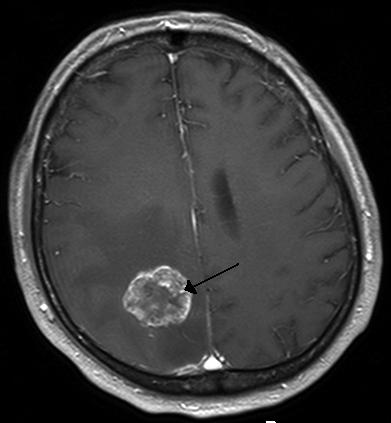

Brain metastasis in the right cerebral hemisphere from lung cancer, shown on magnetic resonance imaging.

Source: Wikipedia

In [ ]:
import os

data_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'

# Get all directories in the data_dir
directories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# Print the directories
print("Directories in the dataset:")
for d in directories:
    print(d)

Directories in the dataset:
no
yes
brain_tumor_dataset


In [ ]:
import os

data_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'

no_tumor_dir = os.path.join(data_dir, 'no')
yes_tumor_dir = os.path.join(data_dir, 'yes')

no_tumor_files = [os.path.join(no_tumor_dir, f) for f in os.listdir(no_tumor_dir) if os.path.isfile(os.path.join(no_tumor_dir, f))]
yes_tumor_files = [os.path.join(yes_tumor_dir, f) for f in os.listdir(yes_tumor_dir) if os.path.isfile(os.path.join(yes_tumor_dir, f))]

print(f"Number of images in 'no' directory: {len(no_tumor_files)}")
print(f"Number of images in 'yes' directory: {len(yes_tumor_files)}")

Number of images in 'no' directory: 98
Number of images in 'yes' directory: 155


---

##  2. Importing Required Libraries

We will now load all the necessary Python libraries for:

- **EDA & Visualizations**: Seaborn, Matplotlib, Plotly
- **Image Handling**: OpenCV, PIL
- **Deep Learning & Transfer Learning**: TensorFlow, Keras, ResNet50/VGG16
- **Evaluation Metrics**: Accuracy, Confusion Matrix, ROC, Classification Report
- **Utilities**: OS, NumPy, Random, etc.

These libraries form the backbone of a professional Computer Vision pipeline.

---


In [ ]:
#install cv2, tensorflow
!pip install opencv-python tensorflow

In [ ]:
# 📦 System & Basic Utilities
import os
import random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 📊 EDA & Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# 🖼 Image Processing
import cv2
from PIL import Image

# 🧠 Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
# 🧪 Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, auc, recall_score

# 🧬 Random Seed for Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

print("✅ All required libraries successfully imported.")

✅ All required libraries successfully imported.


---

## 3. Dataset Loading & Structure Preview

We will now:

-  Load MRI brain scan images from the dataset directory
-  Analyze class balance (Tumor vs No Tumor)
-  Check image dimensions and color format
-  Show random image previews from both classes
-  Visualize class distribution using pie chart and bar plot

---


In [ ]:
# 📁 Dataset Directory Path
dataset_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection"
yes_path = os.path.join(dataset_path, "yes")   # Tumor
no_path = os.path.join(dataset_path, "no")     # No Tumor

# 🗂 Get list of images
yes_images = glob(os.path.join(yes_path, "*.[jpJP][pnPN]*[gG]"))
no_images = glob(os.path.join(no_path, "*.[jpJP][pnPN]*[gG]"))

print(f"🧠 Tumor Images: {len(yes_images)}")
print(f"🧘‍♂️ No Tumor Images: {len(no_images)}")

🧠 Tumor Images: 155
🧘‍♂️ No Tumor Images: 98


### Class Distribution Visualization

In [ ]:
# 📊 Pie Chart
labels = ['Tumor', 'No Tumor']
counts = [len(yes_images), len(no_images)]

fig = go.Figure(data=[go.Pie(labels=labels, values=counts, hole=0.4, marker=dict(colors=['crimson', 'royalblue']))])
fig.update_layout(title="🧬 Class Distribution: Tumor vs No Tumor")
fig.show()


### Image Shape & Color Channel Check


🖼 Sample Image Shape: (298, 260, 3) (H, W, C)


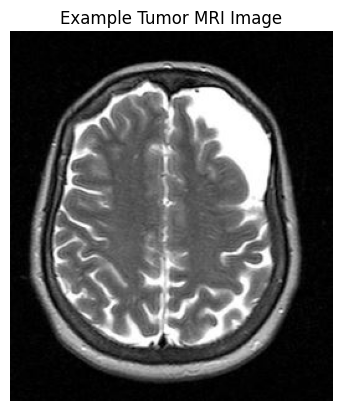

In [ ]:
# 🔍 Check image format (shape and color)
sample_img = cv2.imread(yes_images[0])
print(f"🖼 Sample Image Shape: {sample_img.shape} (H, W, C)")
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
plt.title("Example Tumor MRI Image")
plt.axis('off')
plt.show()


---

##  4. Image Preprocessing & Augmentation Pipeline

To ensure the model generalizes well and learns robust features, we apply the following preprocessing steps:

---

###  Standard Preprocessing

-  **Resize**: All MRI images resized to `(224x224)` — compatible with pre-trained CNNs like VGG16 or ResNet50.
- **Color Handling**: Convert to **RGB** format (some MRI images might be grayscale).
-  **Normalization**: Scale all pixel values from `[0–255]` to `[0–1]` for stable training.

---

###  Data Augmentation

To avoid overfitting and simulate real-world variation in MRIs, we apply:
-  Random Rotation (±15°)
- Zoom (up to 20%)
- ↔ Horizontal Flip
-  Width/Height Shift
-  Brightness Adjustment

This strengthens the model's ability to detect tumors under different scanning conditions.

---


### 4.1 Image Data Generators – Code Cell

In [ ]:
# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42
dataset_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection" # Corrected dataset path

# 🔹 Use for VGG16
train_gen_vgg = ImageDataGenerator(
    preprocessing_function=vgg_preprocess,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

val_gen_vgg = ImageDataGenerator(
    preprocessing_function=vgg_preprocess,
    validation_split=0.2
)

train_data_vgg = train_gen_vgg.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    classes=['no', 'yes'],
    seed=SEED
)

val_data_vgg = val_gen_vgg.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    classes=['no', 'yes'],
    seed=SEED
)

# 🔹 Use for ResNet50
train_gen_resnet = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

val_gen_resnet = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    validation_split=0.2
)

train_data_resnet = train_gen_resnet.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    classes=['no', 'yes'],
    seed=SEED
)

val_data_resnet = val_gen_resnet.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    classes=['no', 'yes'],
    seed=SEED
)

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


---

## 🧠 5. Exploratory Data Analysis (EDA) for MRI Images

Before training, it's critical to visually and statistically analyze the dataset:

###  Goals of Image EDA:
-  Check for noise, blurriness, quality
-  Assess class balance visually
-  Verify image sizes and color channels
-  Visualize pixel intensity distribution
-  Preview samples from both classes
-  Understand mean/variance across dataset

---


### Class Distribution (Bar + Pie Chart)

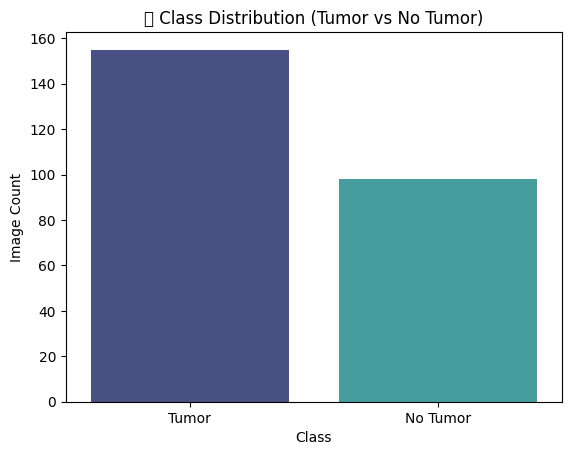

In [ ]:
# Class balance (manually count from folders)
class_counts = {"Tumor": len(yes_images), "No Tumor": len(no_images)}

# Bar chart
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='mako')
plt.title("🧬 Class Distribution (Tumor vs No Tumor)")
plt.ylabel("Image Count")
plt.xlabel("Class")
plt.show()


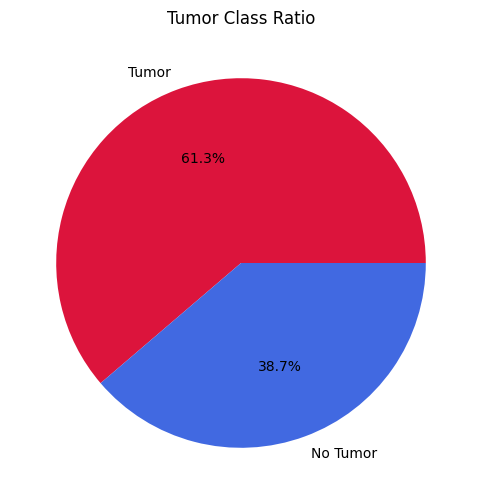

In [ ]:

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', colors=["crimson", "royalblue"])
plt.title("Tumor Class Ratio")
plt.show()


### Sample Thumbnails by Class

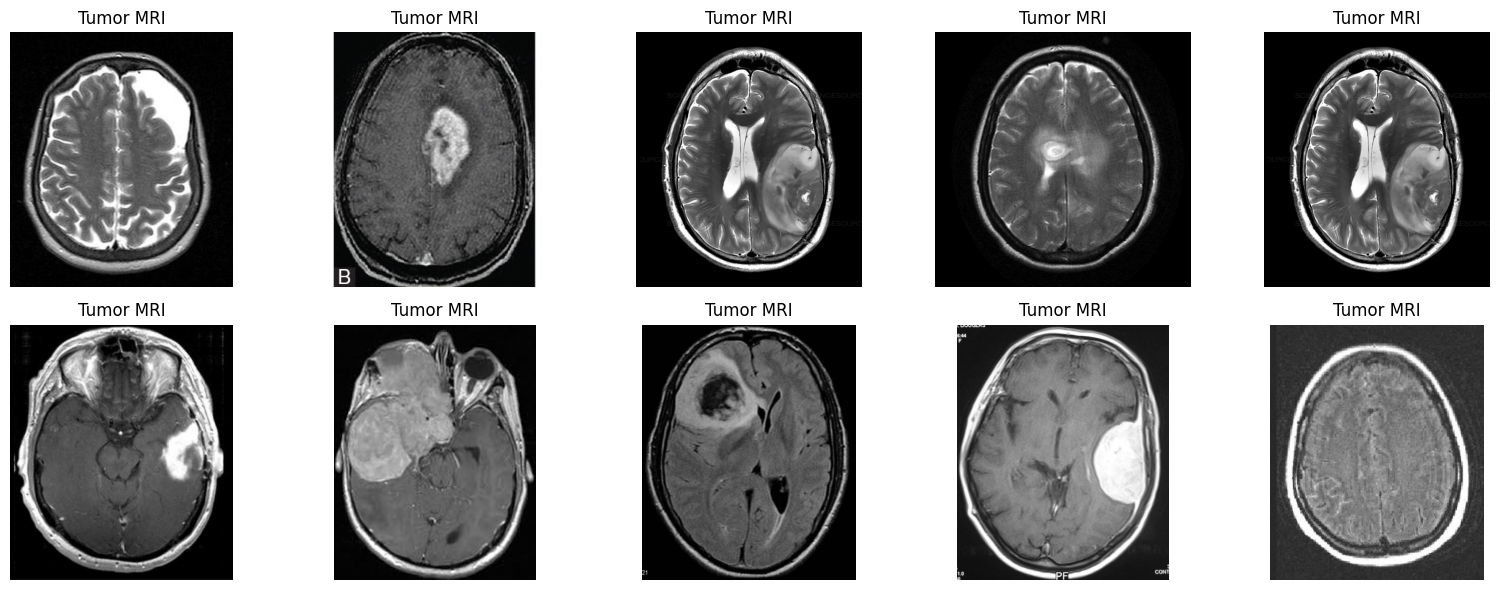

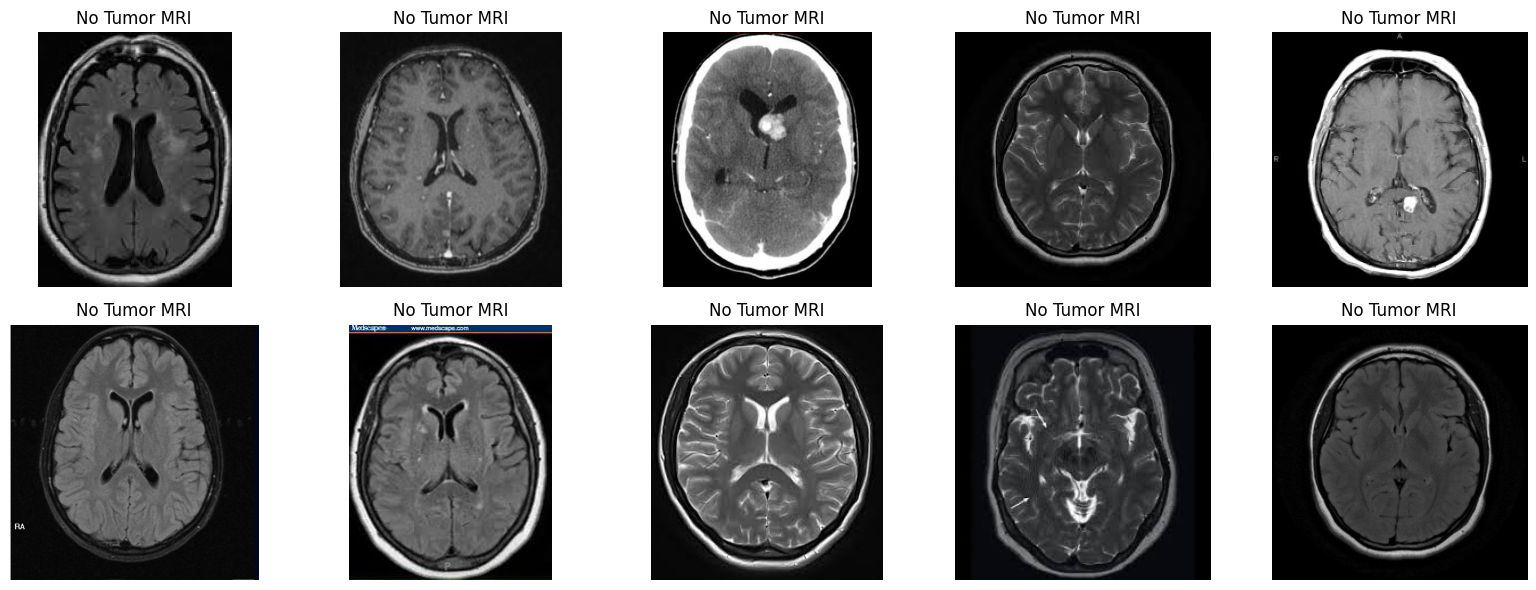

In [ ]:
preview_images(yes_images, "Tumor MRI", rows=2, cols=5)
preview_images(no_images, "No Tumor MRI", rows=2, cols=5)



###  Image Shape & Channel Stats

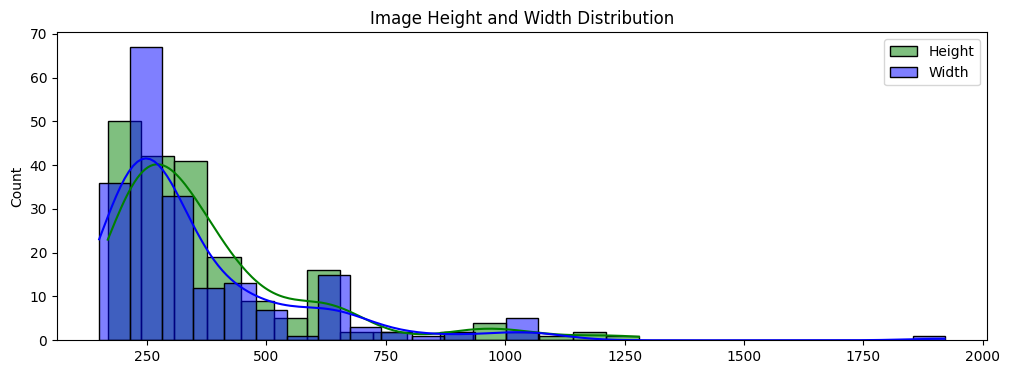

In [ ]:
image_shapes = [cv2.imread(img).shape for img in yes_images[:100] + no_images[:100]]
heights = [shape[0] for shape in image_shapes]
widths = [shape[1] for shape in image_shapes]
channels = [shape[2] for shape in image_shapes]

plt.figure(figsize=(12, 4))
sns.histplot(heights, kde=True, color='green', label='Height')
sns.histplot(widths, kde=True, color='blue', label='Width')
plt.title("Image Height and Width Distribution")
plt.legend()
plt.show()



### Pixel Intensity Histogram

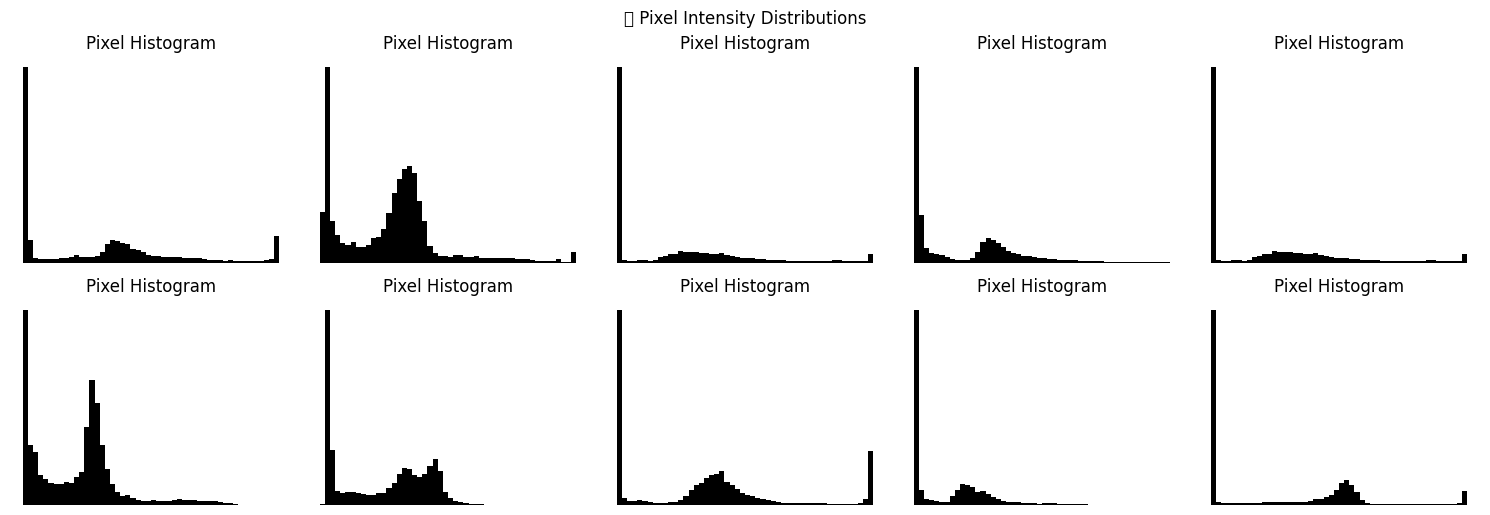

In [ ]:
# Pick few sample images
sample_paths = yes_images[:5] + no_images[:5]

plt.figure(figsize=(15, 5))
for i, path in enumerate(sample_paths):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(2, 5, i+1)
    plt.hist(img.ravel(), bins=50, color='black')
    plt.title("Pixel Histogram")
    plt.axis('off')
plt.tight_layout()
plt.suptitle("🖤 Pixel Intensity Distributions", y=1.02)
plt.show()


---

##  6. Model Selection - Transfer Learning

To achieve high accuracy and fast convergence, we leverage **pretrained CNN architectures**:

###  Why Transfer Learning?

-  Faster convergence on small datasets
-  Rich feature extraction from medical scans
-  Avoids overfitting with frozen base layers

---

###  Selected Architectures:
| Model     | Description                               | Used For       |
|-----------|-------------------------------------------|----------------|
| VGG16     | Deep, simple CNN with uniform layers      | Baseline       |
| ResNet50  | Residual connections, deeper architecture | Performance    |

We'll use:
- Pretrained weights from **ImageNet**
- Freeze convolutional base
- Add custom classification head (GAP + Dense)

---


### Build VGG16 Model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
# Load VGG16 Base
base_vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_vgg.trainable = False  # Freeze convolutional base

# VGG16 Model
model_vgg = Sequential([
    base_vgg,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model_vgg.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model_vgg.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Build ResNet50 Model

In [ ]:
from tensorflow.keras.applications import ResNet50

# Load ResNet50 Base
base_resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_resnet.trainable = False  # Freeze convolutional base

# ResNet50 Model
model_resnet = Sequential([
    base_resnet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model_resnet.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model_resnet.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

---

## ✅ 7. Train Both Models

We'll now train the two transfer learning models:

- ✅ Use `EarlyStopping` to avoid overfitting
- ✅ Use `ModelCheckpoint` to save best weights
- ✅ Train both **VGG16** and **ResNet50**
- 📈 Compare validation accuracy to select the best model

---


### Define Callbacks

In [ ]:
# Early stopping to avoid overfitting
early_stop = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)

# Save best VGG16 model
vgg_ckpt = ModelCheckpoint("best_vgg_model.h5", monitor='val_accuracy', save_best_only=True)

# Save best ResNet50 model
resnet_ckpt = ModelCheckpoint("best_resnet_model.h5", monitor='val_accuracy', save_best_only=True)


###  Train VGG16 Model

In [ ]:
vgg_history = model_vgg.fit(
    train_data_vgg,
    validation_data=val_data_vgg,
    epochs=15,
    callbacks=[early_stop, vgg_ckpt],
    verbose=1
)


Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4703 - loss: 1.6917

7/7 ━━━━━━━━━━━━━━━━━━━━ 58s 8s/step - accuracy: 0.4718 - loss: 1.7169 - val_accuracy: 0.7000 - val_loss: 0.9100
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 56s 8s/step - accuracy: 0.5991 - loss: 1.9049 - val_accuracy: 0.7000 - val_loss: 0.8624
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5423 - loss: 1.6111

7/7 ━━━━━━━━━━━━━━━━━━━━ 56s 9s/step - accuracy: 0.5441 - loss: 1.6096 - val_accuracy: 0.7400 - val_loss: 0.7022
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6289 - loss: 1.5831

7/7 ━━━━━━━━━━━━━━━━━━━━ 56s 8s/step - accuracy: 0.6260 - loss: 1.5920 - val_accuracy: 0.7600 - val_loss: 0.6196
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 56s 8s/step - accuracy: 0.5547 - loss: 1.5663 - val_accuracy: 0.7600 - val_loss: 0.5564
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6290 - loss: 1.2586

7/7 ━━━━━━━━━━━━━━━━━━━━ 56s 8s/step - accuracy: 0.6299 - loss: 1.2451 - val_accuracy: 0.7800 - val_loss: 0.5078
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 56s 8s/step - accuracy: 0.5984 - loss: 1.4375 - val_accuracy: 0.7800 - val_loss: 0.4757
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6934 - loss: 1.0694

7/7 ━━━━━━━━━━━━━━━━━━━━ 56s 8s/step - accuracy: 0.6868 - loss: 1.0862 - val_accuracy: 0.8000 - val_loss: 0.4620
Epoch 9/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 56s 8s/step - accuracy: 0.6648 - loss: 1.0664 - val_accuracy: 0.8000 - val_loss: 0.4270
Epoch 10/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6500 - loss: 1.1274

7/7 ━━━━━━━━━━━━━━━━━━━━ 56s 8s/step - accuracy: 0.6482 - loss: 1.1323 - val_accuracy: 0.8600 - val_loss: 0.3758
Epoch 11/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 56s 8s/step - accuracy: 0.7264 - loss: 0.8660 - val_accuracy: 0.8600 - val_loss: 0.3569
Epoch 12/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 56s 9s/step - accuracy: 0.7482 - loss: 0.7871 - val_accuracy: 0.8600 - val_loss: 0.3348
Epoch 13/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 57s 8s/step - accuracy: 0.7111 - loss: 0.8408 - val_accuracy: 0.8600 - val_loss: 0.3154


 ### Train ResNet50

In [ ]:
resnet_history = model_resnet.fit(
    train_data_resnet,
    validation_data=val_data_resnet,
    epochs=15,
    callbacks=[early_stop, resnet_ckpt],
    verbose=1
)


Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5439 - loss: 0.8182

7/7 ━━━━━━━━━━━━━━━━━━━━ 51s 7s/step - accuracy: 0.5486 - loss: 0.8133 - val_accuracy: 0.6000 - val_loss: 0.6794
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7157 - loss: 0.6334

7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.7093 - loss: 0.6362 - val_accuracy: 0.6600 - val_loss: 0.6009
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6832 - loss: 0.5854

7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.6809 - loss: 0.5874 - val_accuracy: 0.6800 - val_loss: 0.5645
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7616 - loss: 0.5315

7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.7588 - loss: 0.5321 - val_accuracy: 0.8200 - val_loss: 0.5028
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.7413 - loss: 0.4993 - val_accuracy: 0.8200 - val_loss: 0.4546
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7106 - loss: 0.5372

7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.7142 - loss: 0.5323 - val_accuracy: 0.8400 - val_loss: 0.4234
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7987 - loss: 0.4866

7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.7992 - loss: 0.4819 - val_accuracy: 0.8600 - val_loss: 0.4094
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.8111 - loss: 0.4307 - val_accuracy: 0.8400 - val_loss: 0.3827
Epoch 9/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.8249 - loss: 0.4042 - val_accuracy: 0.8400 - val_loss: 0.3686
Epoch 10/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8320 - loss: 0.4152

7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.8327 - loss: 0.4134 - val_accuracy: 0.8800 - val_loss: 0.3622
Epoch 11/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.8559 - loss: 0.3891 - val_accuracy: 0.8800 - val_loss: 0.3445
Epoch 12/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.7910 - loss: 0.4416 - val_accuracy: 0.8600 - val_loss: 0.3271
Epoch 13/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8438 - loss: 0.3725

7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.8436 - loss: 0.3735 - val_accuracy: 0.9000 - val_loss: 0.3290
Epoch 14/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.8128 - loss: 0.3947 - val_accuracy: 0.9000 - val_loss: 0.3240
Epoch 15/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.8625 - loss: 0.3536 - val_accuracy: 0.8800 - val_loss: 0.3042


### Compare Validation Accuracy

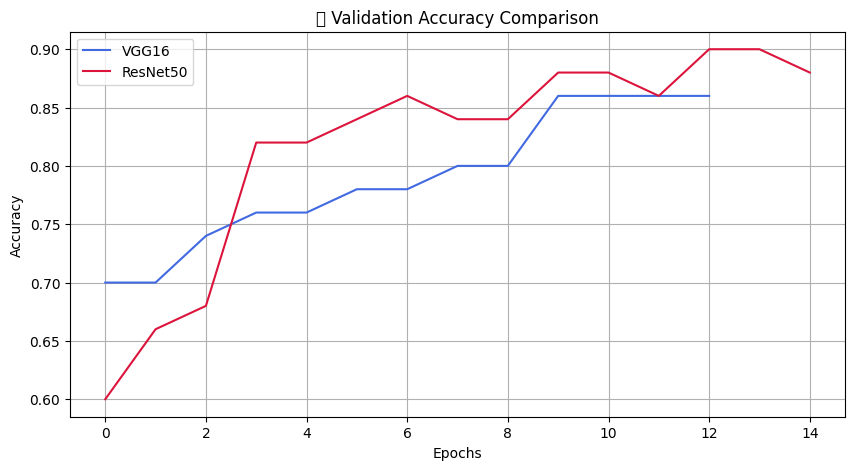

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(vgg_history.history['val_accuracy'], label='VGG16', color='royalblue')
plt.plot(resnet_history.history['val_accuracy'], label='ResNet50', color='crimson')
plt.title("📈 Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


### Auto-select Best Model

In [ ]:
vgg_acc = model_vgg.evaluate(val_data_vgg, verbose=0)[1]
resnet_acc = model_resnet.evaluate(val_data_resnet, verbose=0)[1]

print(f"VGG16 Validation Accuracy   : {vgg_acc:.4f}")
print(f"ResNet50 Validation Accuracy: {resnet_acc:.4f}")

if vgg_acc > resnet_acc:
    print("✅ VGG16 selected as final model")
    model_vgg.save("final_brain_tumor_model.h5")
else:
    print("✅ ResNet50 selected as final model")
    model_resnet.save("final_brain_tumor_model.h5")


VGG16 Validation Accuracy   : 0.8600
ResNet50 Validation Accuracy: 0.9000
✅ ResNet50 selected as final model


---

## ✅ 8. Evaluation & Analysis

To ensure the model is reliable for real-world diagnosis, we evaluate it using:

- ✅ **Accuracy**
- ✅ **Recall** (especially for Tumor class)
- ✅ **Classification Report**
- ✅ **Confusion Matrix**
- ✅ **ROC Curve**
- ✅ **Grad-CAM** for visual interpretation

---


### Predict on Validation Data

In [ ]:
# Predict
y_pred = model_resnet.predict(val_data_resnet)
y_pred_class = (y_pred > 0.5).astype("int32")
y_true = val_data_resnet.classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step


### Classification Report & Accuracy

In [ ]:
print("✅ Classification Report:\n")
print(classification_report(y_true, y_pred_class, target_names=["No Tumor", "Tumor"]))

print(f"✅ Accuracy: {accuracy_score(y_true, y_pred_class):.4f}")
print(f"✅ Recall (Tumor class): {recall_score(y_true, y_pred_class):.4f}")

✅ Classification Report:

              precision    recall  f1-score   support

    No Tumor       0.85      0.89      0.87        19
       Tumor       0.93      0.90      0.92        31

    accuracy                           0.90        50
   macro avg       0.89      0.90      0.89        50
weighted avg       0.90      0.90      0.90        50

✅ Accuracy: 0.9000
✅ Recall (Tumor class): 0.9032


### Confusion Matrix

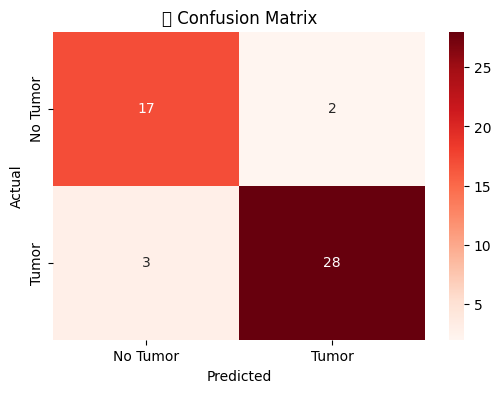

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred_class), annot=True, fmt='d', cmap='Reds', xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.title("📊 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### ROC Curve

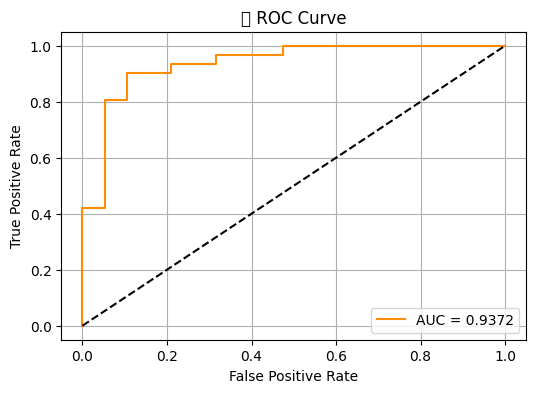

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color="darkorange")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


## Grad-CAM Visualization

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_output = predictions[:, 0]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

In [ ]:
make_gradcam_heatmap

<function __main__.make_gradcam_heatmap(img_array, model, last_conv_layer_name)>

### Apply Grad-CAM on One Image

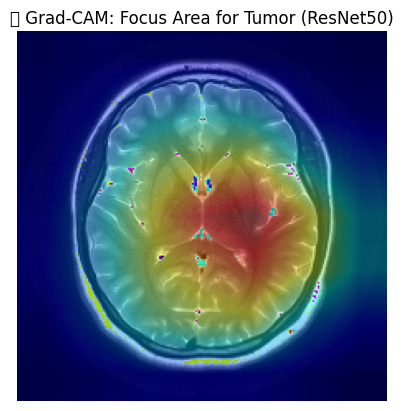

In [ ]:
# Load an image from validation set
img_path = val_data_resnet.filepaths[0]  # You can change index to test others
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = resnet_preprocess(img_array)

# Get the ResNet50 base model from the sequential model
resnet_base_model = model_resnet.layers[0]


last_conv_layer_name = 'conv5_block3_out' # This is a common name in the original ResNet50

# Check if this layer exists in the base model
try:
    resnet_base_model.get_layer(last_conv_layer_name)
except ValueError:

    print(f"Layer '{last_conv_layer_name}' not found directly in the base model. Trying to find the last convolutional layer.")
    last_conv_layer_name = None
    for layer in reversed(resnet_base_model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
             last_conv_layer_name = layer.name
             print(f"Found last Conv2D layer: {last_conv_layer_name}")
             break
    if last_conv_layer_name is None:
        raise ValueError("Could not find a Conv2D layer in the ResNet50 base model.")


# Generate Grad-CAM heatmap for ResNet50
heatmap = make_gradcam_heatmap(img_array, resnet_base_model, last_conv_layer_name)


# Superimpose heatmap on the original image
img_orig = cv2.imread(img_path)
img_orig = cv2.resize(img_orig, (224, 224))
heatmap_resized = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
superimposed = heatmap_colored * 0.4 + img_orig

# Display Grad-CAM
plt.imshow(cv2.cvtColor(superimposed.astype("uint8"), cv2.COLOR_BGR2RGB))
plt.title("🧠 Grad-CAM: Focus Area for Tumor (ResNet50)")
plt.axis('off')
plt.show()

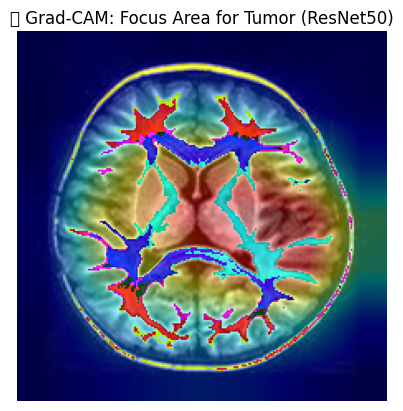

In [ ]:
# Load an image from validation set
img_path = val_data_resnet.filepaths[5]  # You can change index to test others
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = resnet_preprocess(img_array)

# Get the ResNet50 base model from the sequential model
resnet_base_model = model_resnet.layers[0]


last_conv_layer_name = 'conv5_block3_out' # This is a common name in the original ResNet50

# Check if this layer exists in the base model
try:
    resnet_base_model.get_layer(last_conv_layer_name)
except ValueError:

    print(f"Layer '{last_conv_layer_name}' not found directly in the base model. Trying to find the last convolutional layer.")
    last_conv_layer_name = None
    for layer in reversed(resnet_base_model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
             last_conv_layer_name = layer.name
             print(f"Found last Conv2D layer: {last_conv_layer_name}")
             break
    if last_conv_layer_name is None:
        raise ValueError("Could not find a Conv2D layer in the ResNet50 base model.")


# Generate Grad-CAM heatmap for ResNet50
heatmap = make_gradcam_heatmap(img_array, resnet_base_model, last_conv_layer_name)


# Superimpose heatmap on the original image
img_orig = cv2.imread(img_path)
img_orig = cv2.resize(img_orig, (224, 224))
heatmap_resized = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
superimposed = heatmap_colored * 0.4 + img_orig

# Display Grad-CAM
plt.imshow(cv2.cvtColor(superimposed.astype("uint8"), cv2.COLOR_BGR2RGB))
plt.title("🧠 Grad-CAM: Focus Area for Tumor (ResNet50)")
plt.axis('off')
plt.show()

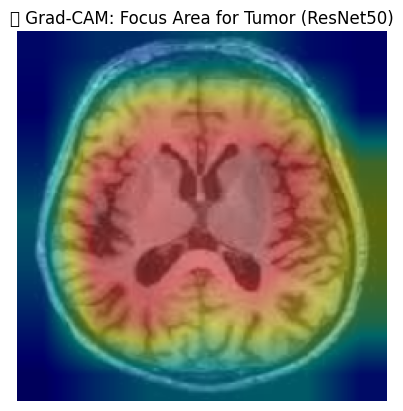

In [ ]:
# Load an image from validation set
img_path = val_data_resnet.filepaths[1]
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = resnet_preprocess(img_array)

# Get the ResNet50 base model from the sequential model
resnet_base_model = model_resnet.layers[0]


last_conv_layer_name = 'conv5_block3_out' # This is a common name in the original ResNet50

# Check if this layer exists in the base model
try:
    resnet_base_model.get_layer(last_conv_layer_name)
except ValueError:

    print(f"Layer '{last_conv_layer_name}' not found directly in the base model. Trying to find the last convolutional layer.")
    last_conv_layer_name = None
    for layer in reversed(resnet_base_model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
             last_conv_layer_name = layer.name
             print(f"Found last Conv2D layer: {last_conv_layer_name}")
             break
    if last_conv_layer_name is None:
        raise ValueError("Could not find a Conv2D layer in the ResNet50 base model.")


# Generate Grad-CAM heatmap for ResNet50
heatmap = make_gradcam_heatmap(img_array, resnet_base_model, last_conv_layer_name)


# Superimpose heatmap on the original image
img_orig = cv2.imread(img_path)
img_orig = cv2.resize(img_orig, (224, 224))
heatmap_resized = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
superimposed = heatmap_colored * 0.4 + img_orig

# Display Grad-CAM
plt.imshow(cv2.cvtColor(superimposed.astype("uint8"), cv2.COLOR_BGR2RGB))
plt.title("🧠 Grad-CAM: Focus Area for Tumor (ResNet50)")
plt.axis('off')
plt.show()